# IV. Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df_residential = pd.read_csv('../Data/DF_Residential_v10.csv')
pd.set_option('max_columns',100)
df_residential.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,PRICE,QUALIFIED,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,SALEYEAR,ayb_age,eyb_age
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1972,1095000.0,Q,2522.0,1,3 Story,1,4,1,Common Brick,1,Hardwood,2.0,5,24,1680,20009.0,38.914680,-77.040832,Old City 2,4201.0,Ward 2,152,NW,2003,108.0,46
1,3,1,Hot Water Rad,Y,2.0,9,3,1908.0,1969,592250.0,Q,1598.0,1,2 Story,1,3,1,Common Brick,0,Hardwood,2.0,1,24,1424,20009.0,38.915019,-77.040138,Old City 2,4201.0,Ward 2,152,NW,2001,110.0,49
2,3,1,Hot Water Rad,Y,1.0,14,5,1880.0,1987,33232.0,U,3465.0,1,3 Story,0,4,1,Common Brick,0,Hardwood,1.0,3,13,2090,20009.0,38.911370,-77.033774,Old City 2,5201.0,Ward 2,208,NW,2016,138.0,31
3,1,0,Forced Air,Y,1.0,6,3,1880.0,1967,907400.0,Q,1790.0,1,2 Story,0,2,1,Common Brick,0,Hardwood,1.0,0,13,2090,20009.0,38.911368,-77.033925,Old City 2,5201.0,Ward 2,208,NW,2006,138.0,51
4,2,1,Forced Air,Y,1.0,5,3,1880.0,1984,1065000.0,Q,1600.0,1,2 Story,0,2,1,Common Brick,0,Hardwood,1.0,1,13,2090,20009.0,38.911368,-77.033972,Old City 2,5201.0,Ward 2,208,NW,2012,138.0,34


In [3]:
df_residential.shape

(53737, 35)

In [4]:
df_residential.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'EYB', 'PRICE', 'QUALIFIED', 'GBA', 'BLDG_NUM', 'STYLE',
       'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'CENSUS_TRACT', 'WARD', 'SQUARE', 'QUADRANT',
       'SALEYEAR', 'ayb_age', 'eyb_age'],
      dtype='object')

## Model Training

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

In [6]:
# Dictionary to keep the assessment of each model
model_assessment = []

# Funtion to assess the model performance
def assess_model(model, model_key, poly=False):
    if poly==True:
        dataset = [[X_train_pr, y_train, 'Training'], [X_val_pr, y_val, 'Validation']]
    else:
        dataset = [[X_train_prepared, y_train, 'Training'], [X_val_prepared, y_val, 'Validation']]
    
    for data in dataset:
        y_pred = model.predict(data[0])
        
        model_assessment.append([model_key,
                               data[2],
                               mean_squared_error(data[1], y_pred),
                               np.sqrt(mean_squared_error(data[1], y_pred)),
                               mean_absolute_error(data[1], y_pred),
                               r2_score(data[1], y_pred)])
        
        print(data[2])
        print('MSE: {}'.format(mean_squared_error(data[1], y_pred)))
        print('RMSE: {}'.format(np.sqrt(mean_squared_error(data[1], y_pred))))
        print('MAE: {}'.format(mean_absolute_error(data[1], y_pred)))
        print('R-squared: {}'.format(r2_score(data[1], y_pred)))
        print('\n')

### 1. Linear Regression

In [7]:
# Splitting Training, Validation, Testing Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM', 'GBA', 'ayb_age', 'eyb_age', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'NUM_UNITS', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE', 'ASSESSMENT_NBHD']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR', 'EXTWALL', 'INTWALL']
label = ['PRICE']

from sklearn.model_selection import train_test_split

X = df_residential[num_cols + onehot_cols + ordinal_cols]
y = df_residential['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)
X_test_prepared = col_transformer.transform(X_test)

In [8]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [9]:
assess_model(lin_reg, 'Linear Regression')

Training
MSE: 19645861093.16832
RMSE: 140163.69391953223
MAE: 105799.11944444603
R-squared: 0.7999913150528081


Validation
MSE: 19031105543.0948
RMSE: 137953.2730423414
MAE: 103854.30281188872
R-squared: 0.8055675704236137




In the Multiple Linear Regression model, we get an underfitting result, so we will try to increase the model's complexity with Polynomial Regression. We do not try using Ridge/Lasso to improve the result of this model as performing Ridge/Lasso will not improve the model significantly because of the underfitting result and there is no multicollinearity in our data.

### 2. Polynomial Regression

In [10]:
# Select different features for polynomial
num_cols_pr = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES']
onehot_cols_pr = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT']
ordinal_cols_pr = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label_pr = ['PRICE']

X_pr = df_residential[num_cols_pr + onehot_cols_pr + ordinal_cols_pr]
y_pr = df_residential['PRICE']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pr, y_pr, test_size=0.3, random_state=22)
X_test_p, X_val_p, y_test_p, y_val_p = train_test_split(X_test_p, y_test_p, test_size=0.5, random_state=22)

col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols_pr),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols_pr),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols_pr)
])

X_train_prepared_pr = col_transformer.fit_transform(X_train_p)
X_val_prepared_pr = col_transformer.transform(X_val_p)
X_test_prepared_pr = col_transformer.transform(X_test_p)

In [11]:
pr = PolynomialFeatures(degree=2, include_bias=False)

X_train_pr = pr.fit_transform(X_train_prepared_pr)
X_val_pr = pr.transform(X_val_prepared_pr)
X_test_pr = pr.transform(X_test_prepared_pr)

In [12]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_pr, y_train_p)

LinearRegression()

In [13]:
assess_model(lin_reg, 'Polynomial Regression', poly=True)

Training
MSE: 13906789440.482952
RMSE: 117927.05135160021
MAE: 85249.8018561827
R-squared: 0.858419101375214


Validation
MSE: 13852055753.544327
RMSE: 117694.7566952085
MAE: 85578.2235638801
R-squared: 0.8584796427779567




After we try to increase the model's complexity with Polynomial Regression and reduce the features, we get a better result. Since the result does not overfit, we will not try to regularize it with Ridge/Lasso.

### 3. Decision Tree Regressor

In [14]:
# Splitting Training, Validation, Testing Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_residential[num_cols + onehot_cols + ordinal_cols]
y = df_residential['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)
X_test_prepared = col_transformer.transform(X_test)

In [15]:
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train_prepared, y_train)
dt.score(X_train_prepared, y_train)

0.9999999482793699

In [16]:
assess_model(dt, 'Decision Tree Regressor')

Training
MSE: 5080.260959723514
RMSE: 71.2759493779179
MAE: 1.060587531569854
R-squared: 0.9999999482793699


Validation
MSE: 19460542657.864437
RMSE: 139501.04894897543
MAE: 90685.02985568374
R-squared: 0.8011802004210744




Since decision tree gives an overfit model, we try random forest to address this issue and to reduce the variance. Random forest will split the training data into multiple samples with replacement (bootstrap sample) and then makes a tree for each bootstrap sample with feature randomization. The majority vote will be the final result.

### 4. Random Forest

In [17]:
rf = RandomForestRegressor(random_state=22)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(random_state=22)

In [18]:
assess_model(rf, 'Random Forest Regressor')

Training
MSE: 1362925494.1739726
RMSE: 36917.820821034016
MAE: 23577.84752640643
R-squared: 0.9861244597791883


Validation
MSE: 9184055656.095436
RMSE: 95833.47878531508
MAE: 62224.82474005549
R-squared: 0.9061705453455751




### 4.1 Random Forest - Tuned

In [19]:
rf = RandomForestRegressor(min_samples_leaf=9, random_state=22)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(min_samples_leaf=9, random_state=22)

In [20]:
assess_model(rf, 'Random Forest Regressor - Tuned')

Training
MSE: 6379519830.009168
RMSE: 79871.89637168488
MAE: 51589.82673902104
R-squared: 0.9350520007372763


Validation
MSE: 9609771150.337467
RMSE: 98029.44022250391
MAE: 64903.55644271399
R-squared: 0.9018211975020483




### 5. Voting Regressor

In [21]:
from sklearn.ensemble import VotingRegressor

In [22]:
ridge = Ridge()

In [23]:
estimators = [
    ('lin_reg', lin_reg),
    ('ridge', ridge),
    ('dt', dt),
    ('rf', rf)
]

In [24]:
np.random.seed(22)
voting_reg = VotingRegressor(
    estimators=estimators
)

voting_reg.fit(X_train_prepared, y_train.ravel())

VotingRegressor(estimators=[('lin_reg', LinearRegression()), ('ridge', Ridge()),
                            ('dt', DecisionTreeRegressor(random_state=0)),
                            ('rf',
                             RandomForestRegressor(min_samples_leaf=9,
                                                   random_state=22))])

In [25]:
assess_model(voting_reg, 'Voting Regressor')

Training
MSE: 7502807825.26592
RMSE: 86618.74984820503
MAE: 63727.49855713362
R-squared: 0.9236161388179229


Validation
MSE: 12372557007.777687
RMSE: 111231.99633099142
MAE: 79811.89399565273
R-squared: 0.8735950303230066




### 6. CatBoost Regressor

In [26]:
from sklearn.base import BaseEstimator

In [27]:
# Splitting Training, Validation, Testing Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
cat_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_residential[num_cols + cat_cols + ordinal_cols]
y = df_residential['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)


class NoTransformer(BaseEstimator):
    """Passes through data without any change and is compatible with ColumnTransformer class"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X


# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols),
    ('no_transformer', NoTransformer(), cat_cols)
])

new_col_names = num_cols + ordinal_cols + cat_cols

X_train_prepared = pd.DataFrame(col_transformer.fit_transform(X_train, y_train), columns=new_col_names)
X_val_prepared = pd.DataFrame(col_transformer.transform(X_val), columns=new_col_names)
X_test_prepared = pd.DataFrame(col_transformer.transform(X_test), columns=new_col_names)

In [28]:
catboost = CatBoostRegressor(verbose=False)
catboost.fit(X_train_prepared, y_train, cat_features=cat_cols)

In [29]:
assess_model(catboost, 'CatBoost Regressor')

Training
MSE: 6204484577.378323
RMSE: 78768.55068730364
MAE: 53174.67346937264
R-squared: 0.9368339827299246


Validation
MSE: 7999273137.579484
RMSE: 89438.65572323572
MAE: 58547.042233575936
R-squared: 0.9182749469040158




### 6. CatBoost Regressor Tuned (FINAL MODEL)

In [30]:
from catboost import Pool

In [31]:
train_pool = Pool(X_train_prepared, y_train, cat_features=cat_cols)
val_pool = Pool(X_val_prepared, y_val, cat_features=cat_cols)
test_pool = Pool(X_test_prepared, y_test, cat_features=cat_cols)

In [32]:
catboost_tuned = CatBoostRegressor(loss_function='MAE', verbose=False)

grid = {'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count' : [32, 255]
       }

grid_search_result = catboost_tuned.grid_search(grid, 
                                       X=train_pool,
                                       plot=True,
                                       verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 64504.46602
bestIteration = 999


bestTest = 62268.1313
bestIteration = 999


bestTest = 61393.27174
bestIteration = 998


bestTest = 61193.69276
bestIteration = 999


bestTest = 64534.78968
bestIteration = 999


bestTest = 62185.67452
bestIteration = 999


bestTest = 61529.53052
bestIteration = 998


bestTest = 61134.07742
bestIteration = 996


bestTest = 64474.56918
bestIteration = 999


bestTest = 62210.26745
bestIteration = 999


bestTest = 61548.04299
bestIteration = 999


bestTest = 60906.04515
bestIteration = 999


bestTest = 64513.43128
bestIteration = 999


bestTest = 62254.41076
bestIteration = 998


bestTest = 61553.95443
bestIteration = 999


bestTest = 60922.79777
bestIteration = 999


bestTest = 64491.53521
bestIteration = 999


bestTest = 62292.45027
bestIteration = 999


bestTest = 61604.71214
bestIteration = 999


bestTest = 61023.20386
bestIteration = 998


bestTest = 60919.03858
bestIteration = 999


bestTest = 60051.89267
bestIteration = 999


bestTest =

In [33]:
assess_model(catboost_tuned, 'CatBoost Regressor - Tuned')

Training
MSE: 6073610249.197364
RMSE: 77933.37057510963
MAE: 47284.155797827705
R-squared: 0.9381663754486089


Validation
MSE: 7897811687.504104
RMSE: 88869.63310098734
MAE: 56658.21314935947
R-squared: 0.9193115338853568




In [34]:
catboost_tuned.get_params()

{'learning_rate': 0.07,
 'depth': 8,
 'l2_leaf_reg': 5,
 'loss_function': 'MAE',
 'border_count': 255,
 'verbose': False}

### Feature Importance and SHAP

In [35]:
# Make a feature importances dataframe
df_feature_importances = pd.DataFrame(catboost_tuned.feature_importances_, new_col_names).reset_index().rename(columns={'index':'Features', 0:'Score'})
df_feature_importances

,Features,Score
0,BATHRM,3.590465
1,HF_BATHRM,0.667259
2,ROOMS,0.559389
3,BEDRM,1.013508
4,ayb_age,3.115100
5,eyb_age,3.565790
6,GBA,7.501115
7,KITCHENS,0.134764
8,FIREPLACES,2.184286
9,LANDAREA,2.282023


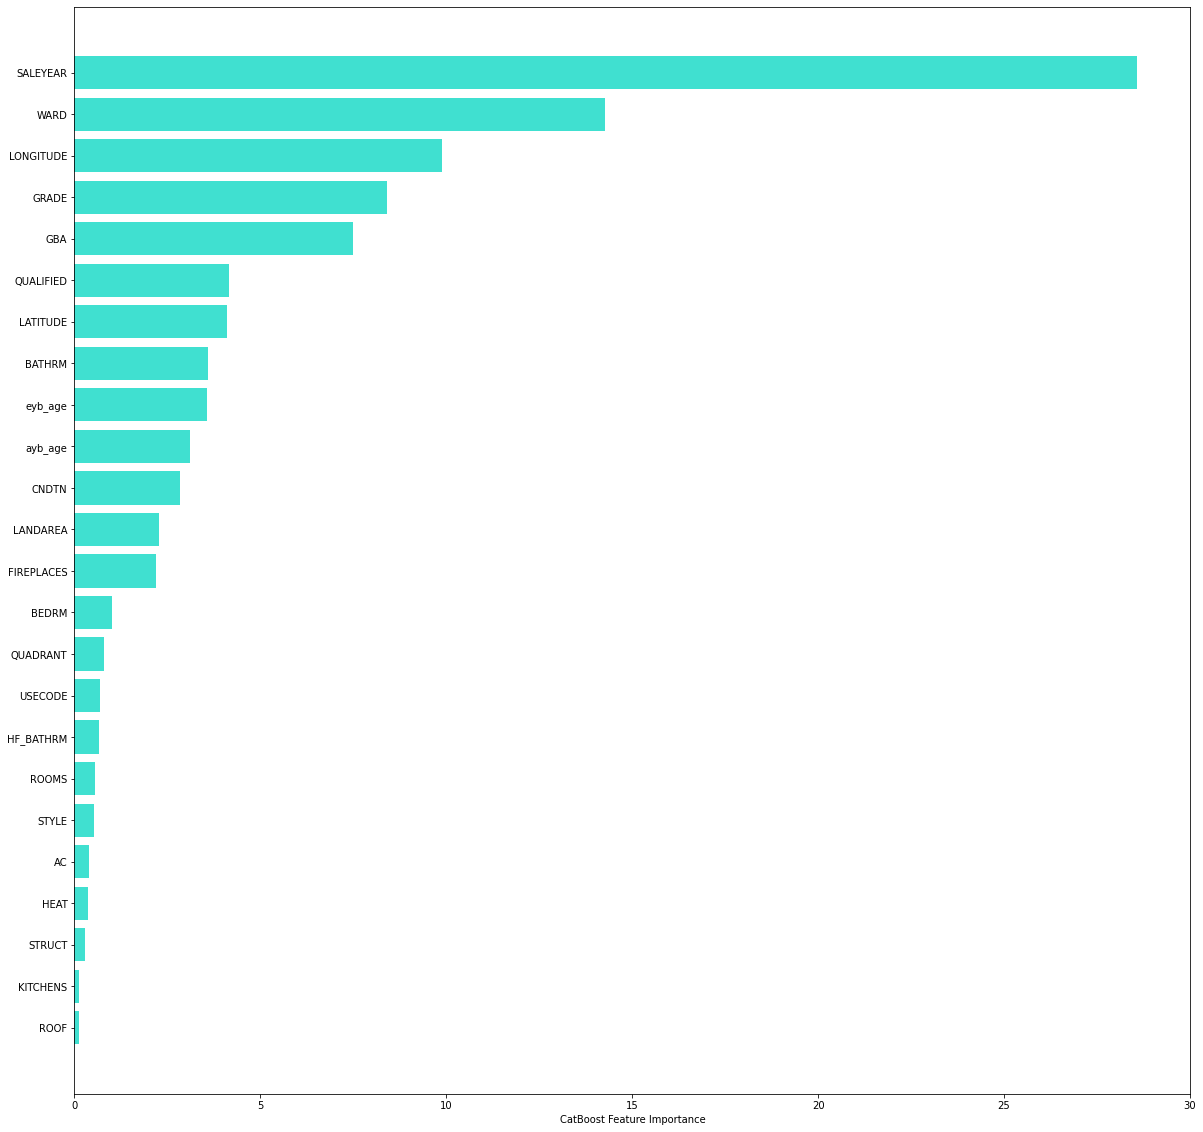

In [36]:
plt.figure(figsize=(20,20))
plt.barh(width='Score', 
         y='Features',
         data=df_feature_importances.sort_values(by='Score'),
         color='turquoise')
plt.xlabel("CatBoost Feature Importance");

In [37]:
import shap

reference for shap : https://github.com/slundberg/shap

In [38]:
explainer = shap.Explainer(catboost)
shap_values = explainer(X_train_prepared)

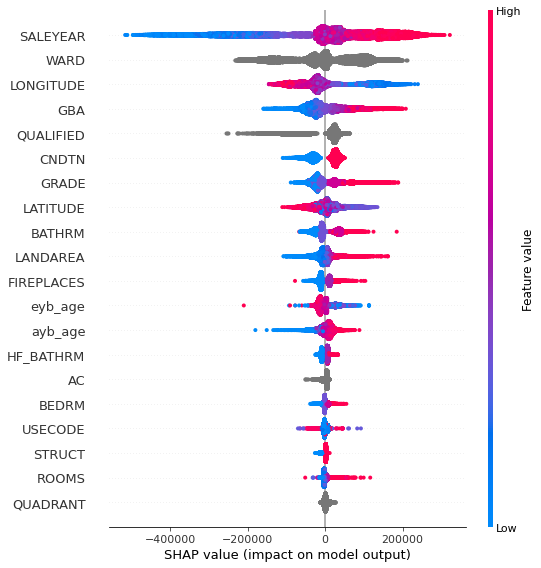

In [39]:
shap.summary_plot(shap_values)

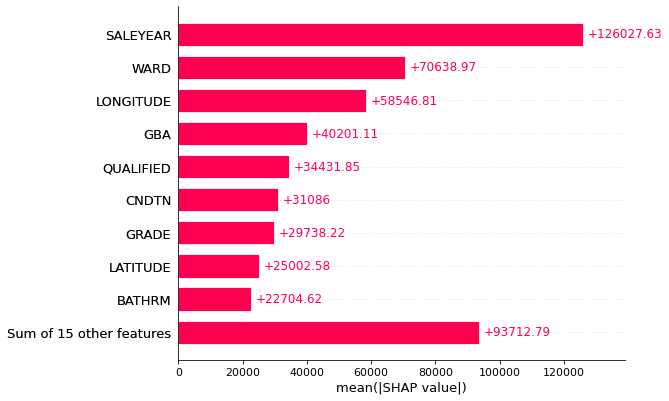

In [40]:
shap.plots.bar(shap_values)

From the CatBoost Feature Importance and SHAP Value (Summary Plot) above, we obtain several insights:
- The most important feature is `SALEYEAR`. The `SALEYEAR` Data also have a long datapoints spread, which would affect the prediction result proportionally. The lower the `SALEYEAR`, the result would be more affected negatively, and vice versa.
- There are grey colours in SHAP Value plot, this shows the categorical columns that is used as cat_cols in CatBoost Regressor model.
- The five most important features are `SALEYEAR`, `WARD`, `LONGITUDE`, `GBA`, and `QUALIFIED`.

### Model Assessment

In [41]:
# Store all assessment results in a dataframe
df_model_result = pd.DataFrame(data=model_assessment, columns=['Model', 'Set', 'MSE', 'RMSE', 'MAE', 'R2'])
df_model_result

,Model,Set,MSE,RMSE,MAE,R2
0,Linear Regression,Training,1.964586e+10,140163.693920,105799.119444,0.799991
1,Linear Regression,Validation,1.903111e+10,137953.273042,103854.302812,0.805568
2,Polynomial Regression,Training,1.390679e+10,117927.051352,85249.801856,0.858419
3,Polynomial Regression,Validation,1.385206e+10,117694.756695,85578.223564,0.858480
4,Decision Tree Regressor,Training,5.080261e+03,71.275949,1.060588,1.000000
5,Decision Tree Regressor,Validation,1.946054e+10,139501.048949,90685.029856,0.801180
6,Random Forest Regressor,Training,1.362925e+09,36917.820821,23577.847526,0.986124
7,Random Forest Regressor,Validation,9.184056e+09,95833.478785,62224.824740,0.906171
8,Random Forest Regressor - Tuned,Training,6.379520e+09,79871.896372,51589.826739,0.935052
9,Random Forest Regressor - Tuned,Validation,9.609771e+09,98029.440223,64903.556443,0.901821


In [42]:
df_model_result[(df_model_result['Set'] == 'Validation')]

,Model,Set,MSE,RMSE,MAE,R2
1,Linear Regression,Validation,1.903111e+10,137953.273042,103854.302812,0.805568
3,Polynomial Regression,Validation,1.385206e+10,117694.756695,85578.223564,0.858480
5,Decision Tree Regressor,Validation,1.946054e+10,139501.048949,90685.029856,0.801180
7,Random Forest Regressor,Validation,9.184056e+09,95833.478785,62224.824740,0.906171
9,Random Forest Regressor - Tuned,Validation,9.609771e+09,98029.440223,64903.556443,0.901821
11,Voting Regressor,Validation,1.237256e+10,111231.996331,79811.893996,0.873595
13,CatBoost Regressor,Validation,7.999273e+09,89438.655723,58547.042234,0.918275
15,CatBoost Regressor - Tuned,Validation,7.897812e+09,88869.633101,56658.213149,0.919312


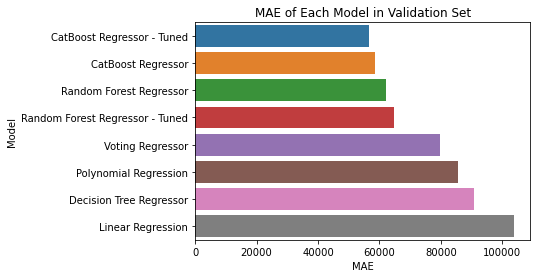

In [43]:
sns.barplot(data=df_model_result[(df_model_result['Set'] == 'Validation')].sort_values(by='MAE'),
            x='MAE', y='Model')
plt.title('MAE of Each Model in Validation Set')
plt.savefig('../Model/Model.png', bbox_inches = 'tight')
plt.show()

### Cross Validation

In [44]:
catboost_tuned = CatBoostRegressor(verbose=False, loss_function='MAE', border_count=255, depth=8, l2_leaf_reg=5, learning_rate=0.07, cat_features=cat_cols)

In [45]:
scores_train = cross_val_score(catboost_tuned, X_train_prepared, y_train, cv=5, scoring='r2')
print('Training Cross Validation Scores')
print('Mean :', scores_train.mean())
print('Std :', scores_train.std())

Training Cross Validation Scores
Mean : 0.9137706764705207
Std : 0.0034701221878056156


## Final Model

We use CatBoost Regressor as our final model as it gives the best R$^2$ results in both training and validation set and the lowest MAE compared with other models. CatBoost Regressor is also more resource efficient than Random Forest Regressor. 

### Merge Training Set with Validation Set

In [46]:
# Export df_train and df_test for final model
df_train_1 = pd.concat([X_train, y_train], axis=1)
df_train_2 = pd.concat([X_val, y_val], axis=1)
df_train = pd.concat([df_train_1, df_train_2], axis=0)

df_test = pd.concat([X_test, y_test], axis=1)

In [47]:
# Export clean df_train to csv
df_train.to_csv('../Data/DF_Train.csv', index=False)

In [48]:
# Export clean df_test to csv
df_test.to_csv('../Data/DF_Test.csv', index=False)

### Re-train Model

In [49]:
df_train = pd.read_csv('../Data/DF_Train.csv')

num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
cat_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

# Data Pre-processing
X_train = df_train[num_cols + cat_cols + ordinal_cols]
y_train = df_train['PRICE']

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols),
    ('no_transformer', NoTransformer(), cat_cols)
])

new_col_names = num_cols + ordinal_cols + cat_cols

X_train_prepared = pd.DataFrame(col_transformer.fit_transform(X_train, y_train), columns=new_col_names)

In [50]:
catboost_final = CatBoostRegressor(
    verbose=False, loss_function='MAE', border_count=255, depth=8, l2_leaf_reg=5, learning_rate=0.07, cat_features=cat_cols)
catboost_final.fit(X_train_prepared, y_train, verbose=100)

0:	learn: 236589.7941672	total: 43.9ms	remaining: 43.8s
100:	learn: 64859.1136362	total: 4.61s	remaining: 41s
200:	learn: 58389.9490439	total: 9.47s	remaining: 37.6s
300:	learn: 55063.8521046	total: 15s	remaining: 34.8s
400:	learn: 52834.5401705	total: 19.6s	remaining: 29.3s
500:	learn: 51310.6846922	total: 24.5s	remaining: 24.4s
600:	learn: 50075.8996138	total: 29.1s	remaining: 19.3s
700:	learn: 49021.0237656	total: 33.8s	remaining: 14.4s
800:	learn: 48186.4539164	total: 38.2s	remaining: 9.5s
900:	learn: 47396.5469092	total: 43s	remaining: 4.73s
999:	learn: 46734.5936498	total: 47.7s	remaining: 0us


In [51]:
model_dict = {
    'transformer' : col_transformer,
    'model' : catboost_final
}

In [52]:
y_pred = model_dict['model'].predict(model_dict['transformer'].transform(X_train))
print('MSE: {}'.format(mean_squared_error(y_train, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_train, y_pred)))
print('R-squared: {}'.format(r2_score(y_train, y_pred)))
print('\n')

MSE: 6079714453.015866
RMSE: 77972.52370557122
MAE: 47183.05421572207
R-squared: 0.9380661353784469




#### Target Metrics Evaluation

In [53]:
price_med = df_residential['PRICE'].median()
des_mae = 0.13 * price_med

print('Price median : {}\nDesired MAE (13% * median) : {}\nAchieved MAE : {}'.format(price_med, des_mae, mean_absolute_error(y_train, y_pred)))

Price median : 410000.0
Desired MAE (13% * median) : 53300.0
Achieved MAE : 47183.05421572207


<b> From the result shown above, we have achieved the desired MAE metrics value of under 53300. <b/>

---

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


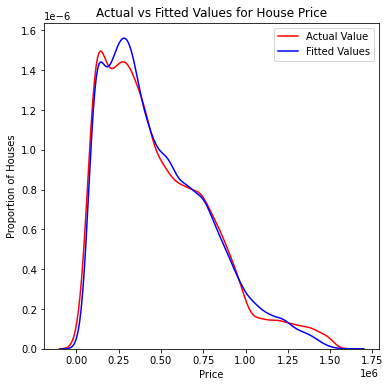

In [54]:
# Distribution plot
plt.figure(figsize=(6, 6))

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for House Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')

plt.legend()
plt.show()
plt.close()

In [55]:
df_results = pd.DataFrame({
    'Actual': y_train.tolist(),
    'Prediction': y_pred.tolist()
})

df_results['Error'] = df_results['Prediction'] - df_results['Actual']
df_results

,Actual,Prediction,Error
0,210000.0,202712.211639,-7287.788361
1,250000.0,260013.587292,10013.587292
2,685000.0,709602.569461,24602.569461
3,798500.0,824351.569773,25851.569773
4,350000.0,344071.276556,-5928.723444
...,...,...,...
45671,250000.0,235400.579341,-14599.420659
45672,500000.0,622668.637539,122668.637539
45673,505000.0,547424.916961,42424.916961
45674,585000.0,464589.502874,-120410.497126


In [56]:
df_results[['Error']].describe()

,Error
count,4.567600e+04
mean,4.389612e+02
std,7.797214e+04
min,-7.969335e+05
25%,-2.712129e+04
50%,-2.071789e+02
75%,2.693634e+04
max,1.292926e+06


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Error'>

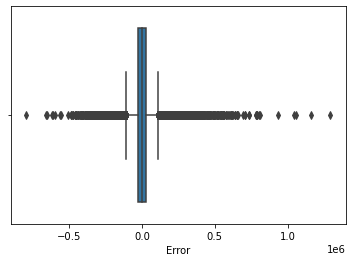

In [61]:
sns.boxplot(df_results['Error'])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


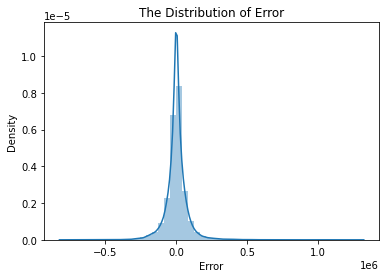

In [62]:
sns.distplot(df_results['Error'])
plt.title("The Distribution of Error")
plt.show()

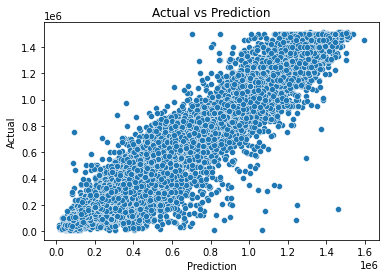

In [63]:
# Residual Analysis
sns.scatterplot(x='Prediction', y='Actual', data=df_results)
plt.title("Actual vs Prediction")
plt.show()

From the analysis results above, we can see that there are many outliers in residuals, so we decide to use MAE as our standard error instead of RMSE as RMSE is very sensitive to outliers. 

In [65]:
scores_train = cross_val_score(model_dict['model'], X_train, y_train, cv=5, scoring='r2', error_score="raise")
print('Training Cross Validation Scores')
print('Mean :', scores_train.mean())
print('Std :', scores_train.std())

Training Cross Validation Scores
Mean : 0.9157272844086888
Std : 0.003736664180184315


### Evaluate Model

In [66]:
df_test = pd.read_csv('../Data/DF_Test.csv')

X_test = df_test.drop('PRICE', axis=1)
y_test = df_test['PRICE']

y_pred = model_dict['model'].predict(model_dict['transformer'].transform(X_test))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))
print('\n')

MSE: 7307725567.58184
RMSE: 85485.23596260257
MAE: 55157.87421335401
R-squared: 0.9249561938597425




`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


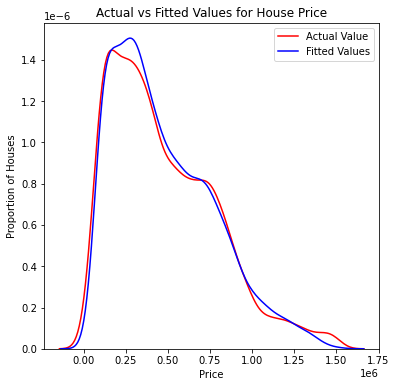

In [67]:
# Distribution plot
plt.figure(figsize=(6, 6))

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for House Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')
plt.legend()
plt.show()
plt.close()

### Save Model

In [68]:
import pickle
import warnings
warnings.filterwarnings('ignore')

# Pickle the model
pickle_filename = '../Model/Final_Model_Catboost_v2.sav'
with open(pickle_filename, 'wb') as f:
    pickle.dump(model_dict, f)